In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', [])
categorical_cols = feature_selection.get('categorical', [])

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))

Numerical features: 296
Categorical features: 5


In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 368
Categorical Columns: 5


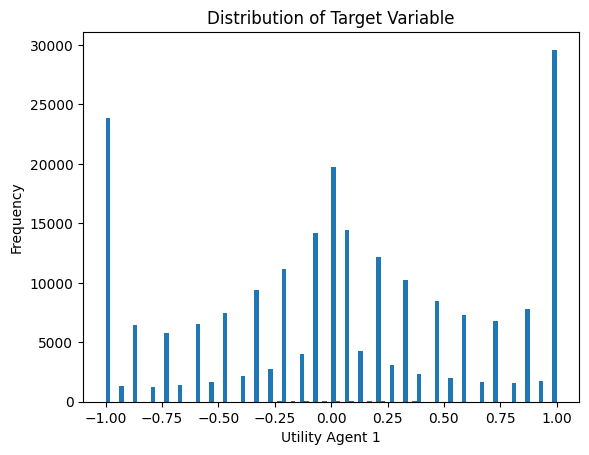

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [6]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [7]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        'objective': "regression",
        'extra_trees': True,
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'max_depth': 10,
        'learning_rate': 0.1,
        'reg_alpha': 1e-1,
        'reg_lambda': 1e-1,
        'feature_fraction': 0.8,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=2000,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=50),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(8, 20), importance_type='gain', max_num_features=100)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1


[50]	valid_0's rmse: 0.473944


[100]	valid_0's rmse: 0.462672


[150]	valid_0's rmse: 0.456403


[200]	valid_0's rmse: 0.451181


[250]	valid_0's rmse: 0.448056


[300]	valid_0's rmse: 0.445413


[350]	valid_0's rmse: 0.443777


[400]	valid_0's rmse: 0.442282


[450]	valid_0's rmse: 0.44152


[500]	valid_0's rmse: 0.440642


[550]	valid_0's rmse: 0.439467


[600]	valid_0's rmse: 0.438884


[650]	valid_0's rmse: 0.438525


[700]	valid_0's rmse: 0.438234


[750]	valid_0's rmse: 0.43772


[800]	valid_0's rmse: 0.43736


[850]	valid_0's rmse: 0.437206


[900]	valid_0's rmse: 0.436883


[950]	valid_0's rmse: 0.436698


[1000]	valid_0's rmse: 0.436642


[1050]	valid_0's rmse: 0.436495


[1100]	valid_0's rmse: 0.436592


[1150]	valid_0's rmse: 0.436514


[1200]	valid_0's rmse: 0.436232


[1250]	valid_0's rmse: 0.436171


[1300]	valid_0's rmse: 0.436024


[1350]	valid_0's rmse: 0.435956


[1400]	valid_0's rmse: 0.435777


[1450]	valid_0's rmse: 0.435695


[1500]	valid_0's rmse: 0.435746


[1550]	valid_0's rmse: 0.435714


[1600]	valid_0's rmse: 0.435748


[1650]	valid_0's rmse: 0.435686


[1700]	valid_0's rmse: 0.43553


[1750]	valid_0's rmse: 0.43545


[1800]	valid_0's rmse: 0.435471


[1850]	valid_0's rmse: 0.435432


[1900]	valid_0's rmse: 0.435581


[1950]	valid_0's rmse: 0.435583


[2000]	valid_0's rmse: 0.435558


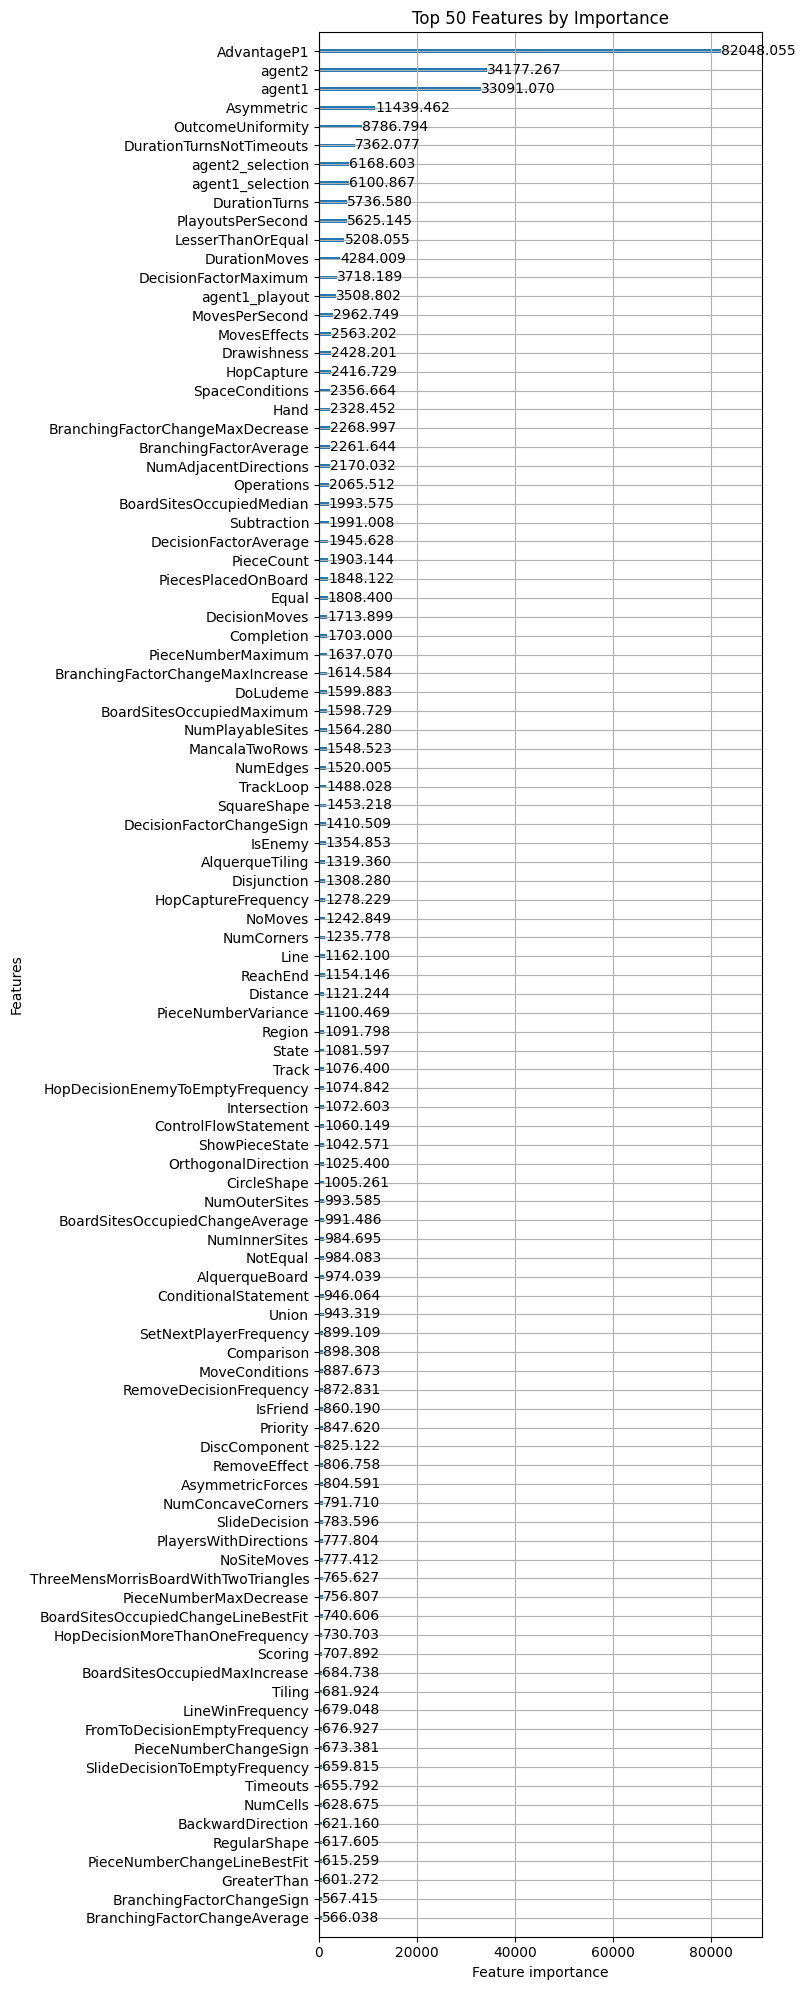

Fold 1 - RMSE: 0.4347528759489758
Fold 2


[50]	valid_0's rmse: 0.492198


[100]	valid_0's rmse: 0.477676


[150]	valid_0's rmse: 0.469054


[200]	valid_0's rmse: 0.465172


[250]	valid_0's rmse: 0.462788


[300]	valid_0's rmse: 0.460307


[350]	valid_0's rmse: 0.458672


[400]	valid_0's rmse: 0.458583


[450]	valid_0's rmse: 0.4574


[500]	valid_0's rmse: 0.457488


[550]	valid_0's rmse: 0.456658


[600]	valid_0's rmse: 0.456043


[650]	valid_0's rmse: 0.455165


[700]	valid_0's rmse: 0.454441


[750]	valid_0's rmse: 0.454369


[800]	valid_0's rmse: 0.454194


[850]	valid_0's rmse: 0.454037


[900]	valid_0's rmse: 0.453721


[950]	valid_0's rmse: 0.453829


[1000]	valid_0's rmse: 0.453658


[1050]	valid_0's rmse: 0.453591


[1100]	valid_0's rmse: 0.453259


[1150]	valid_0's rmse: 0.452957


[1200]	valid_0's rmse: 0.452445


[1250]	valid_0's rmse: 0.452491


[1300]	valid_0's rmse: 0.452277


[1350]	valid_0's rmse: 0.452297


[1400]	valid_0's rmse: 0.452162


[1450]	valid_0's rmse: 0.452125


[1500]	valid_0's rmse: 0.452022


[1550]	valid_0's rmse: 0.452227


[1600]	valid_0's rmse: 0.45191


[1650]	valid_0's rmse: 0.452015


[1700]	valid_0's rmse: 0.452152


[1750]	valid_0's rmse: 0.451907


[1800]	valid_0's rmse: 0.451931


[1850]	valid_0's rmse: 0.451996


[1900]	valid_0's rmse: 0.451898


[1950]	valid_0's rmse: 0.45193


[2000]	valid_0's rmse: 0.451854


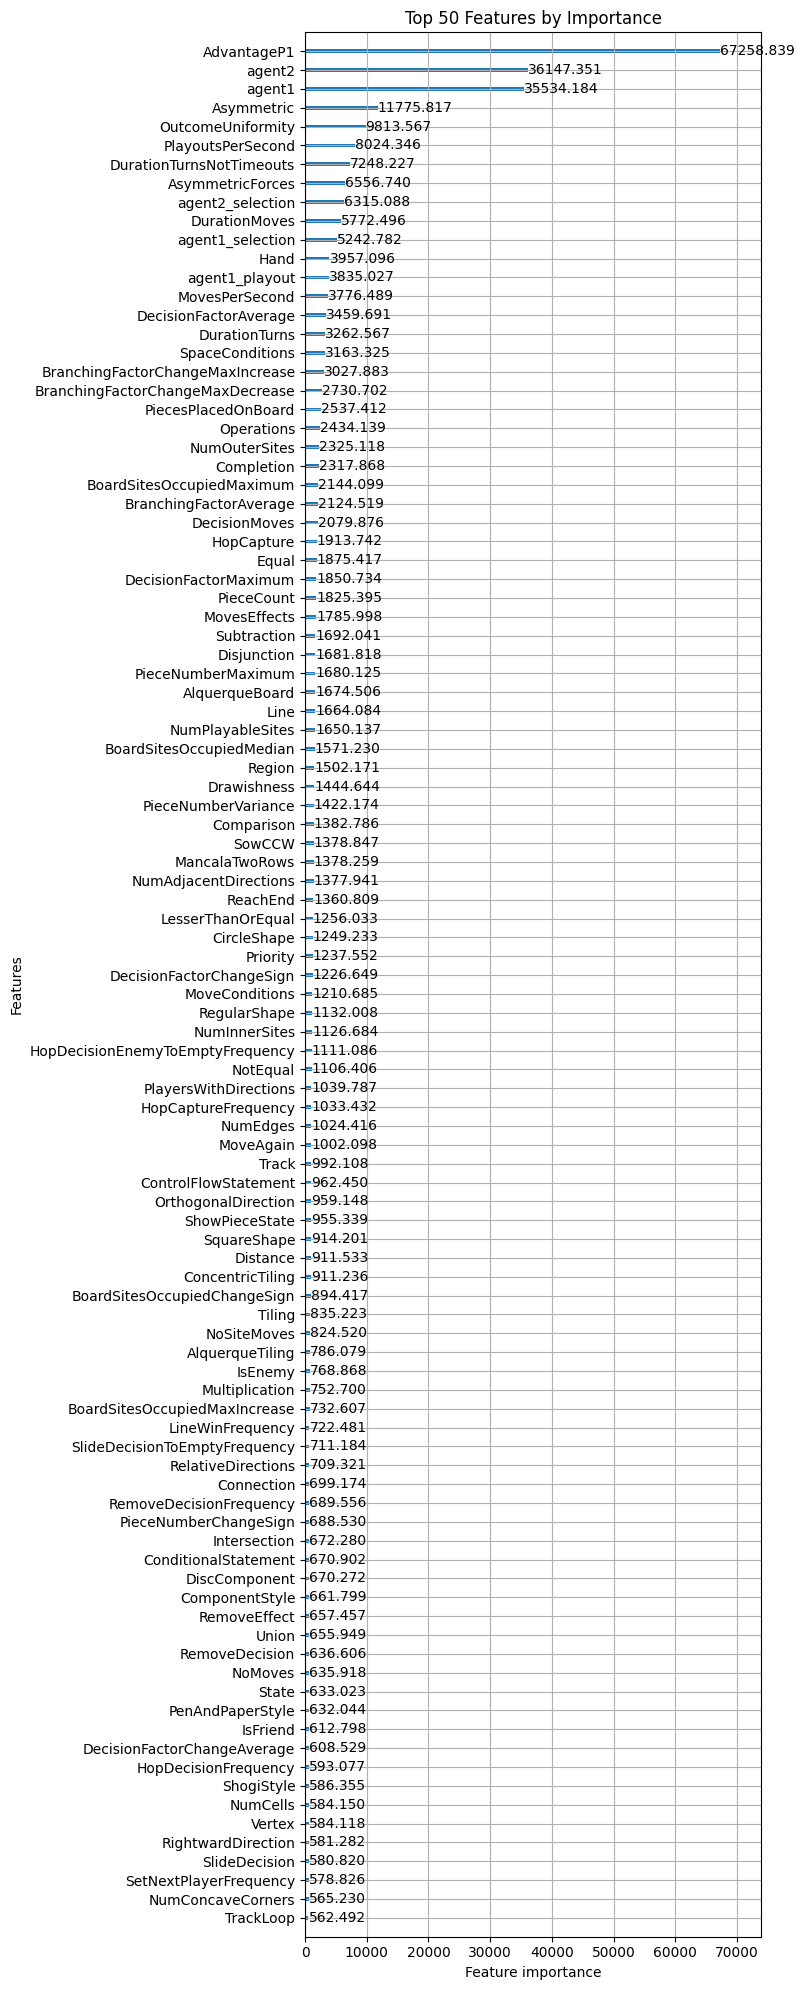

Fold 2 - RMSE: 0.45103594175409284
Fold 3


[50]	valid_0's rmse: 0.480306


[100]	valid_0's rmse: 0.466266


[150]	valid_0's rmse: 0.459928


[200]	valid_0's rmse: 0.455592


[250]	valid_0's rmse: 0.453854


[300]	valid_0's rmse: 0.451345


[350]	valid_0's rmse: 0.449518


[400]	valid_0's rmse: 0.448833


[450]	valid_0's rmse: 0.448026


[500]	valid_0's rmse: 0.447605


[550]	valid_0's rmse: 0.44699


[600]	valid_0's rmse: 0.446598


[650]	valid_0's rmse: 0.445956


[700]	valid_0's rmse: 0.445994


[750]	valid_0's rmse: 0.445571


[800]	valid_0's rmse: 0.445187


[850]	valid_0's rmse: 0.445149


[900]	valid_0's rmse: 0.445309


[950]	valid_0's rmse: 0.445191


[1000]	valid_0's rmse: 0.444755


[1050]	valid_0's rmse: 0.444962


[1100]	valid_0's rmse: 0.445028


[1150]	valid_0's rmse: 0.444923


[1200]	valid_0's rmse: 0.444584


[1250]	valid_0's rmse: 0.444477


[1300]	valid_0's rmse: 0.444277


[1350]	valid_0's rmse: 0.444006


[1400]	valid_0's rmse: 0.443661


[1450]	valid_0's rmse: 0.443516


[1500]	valid_0's rmse: 0.443496


[1550]	valid_0's rmse: 0.443239


[1600]	valid_0's rmse: 0.443084


[1650]	valid_0's rmse: 0.44308


[1700]	valid_0's rmse: 0.443093


[1750]	valid_0's rmse: 0.443066


[1800]	valid_0's rmse: 0.443003


[1850]	valid_0's rmse: 0.442977


[1900]	valid_0's rmse: 0.442934


[1950]	valid_0's rmse: 0.442865


[2000]	valid_0's rmse: 0.442786


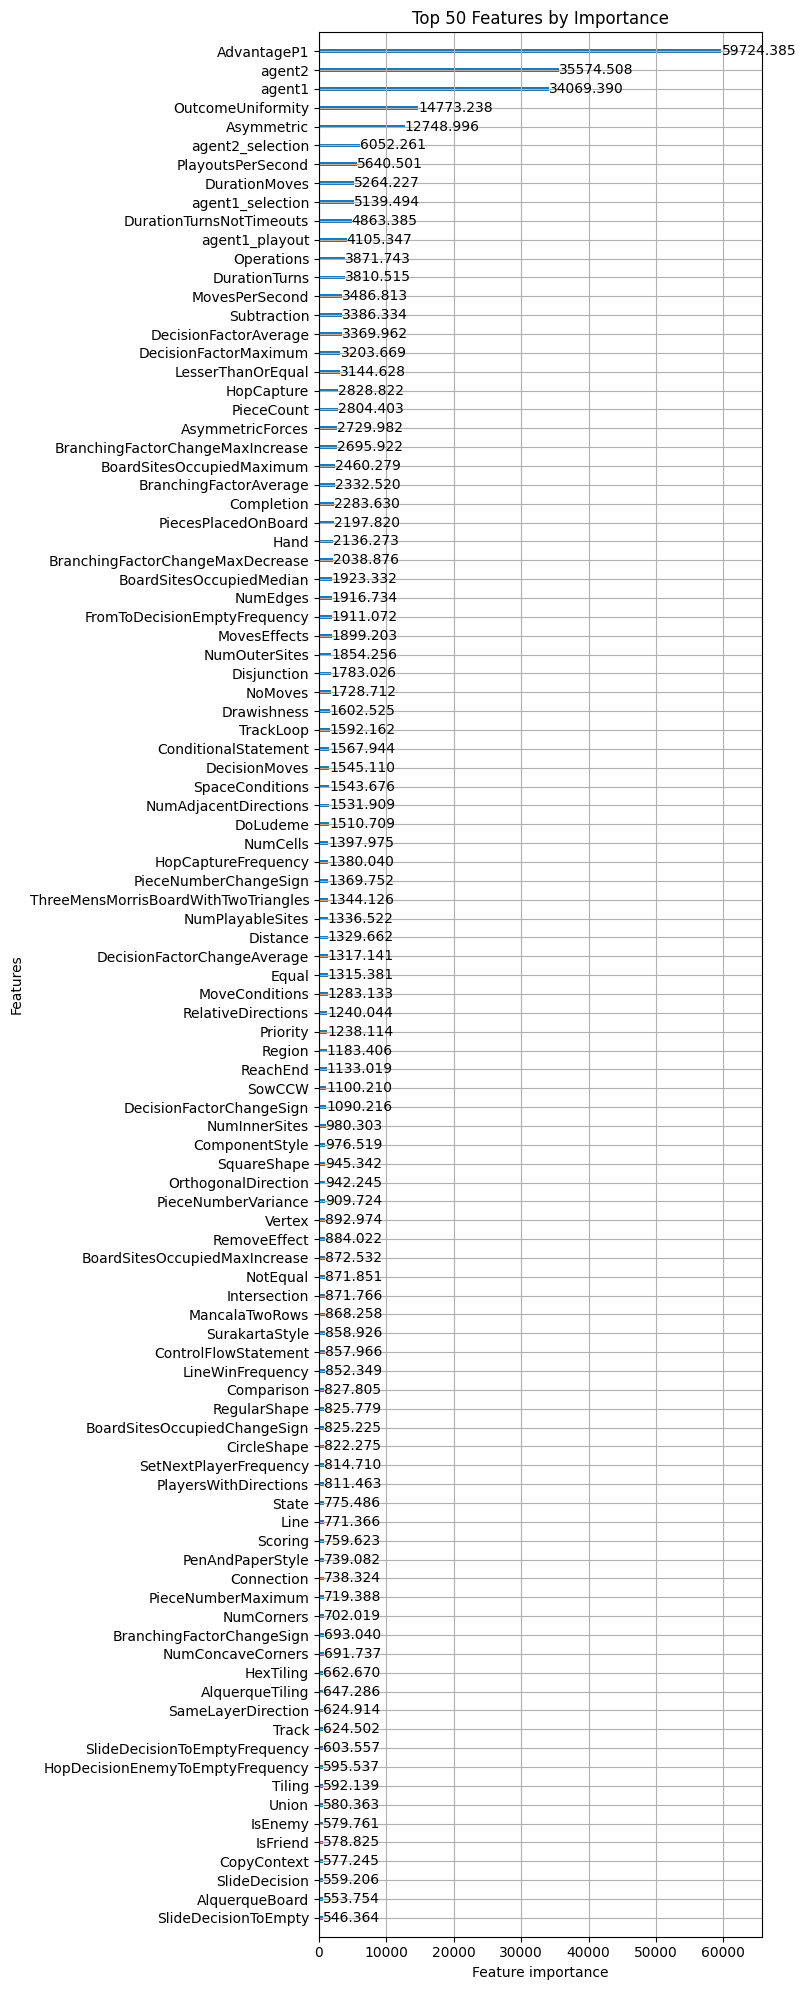

Fold 3 - RMSE: 0.4418425431441224
Fold 4


[50]	valid_0's rmse: 0.50318


[100]	valid_0's rmse: 0.489881


[150]	valid_0's rmse: 0.483279


[200]	valid_0's rmse: 0.480296


[250]	valid_0's rmse: 0.477329


[300]	valid_0's rmse: 0.474878


[350]	valid_0's rmse: 0.473324


[400]	valid_0's rmse: 0.472266


[450]	valid_0's rmse: 0.471118


[500]	valid_0's rmse: 0.469865


[550]	valid_0's rmse: 0.469168


[600]	valid_0's rmse: 0.468246


[650]	valid_0's rmse: 0.467734


[700]	valid_0's rmse: 0.467107


[750]	valid_0's rmse: 0.466547


[800]	valid_0's rmse: 0.466192


[850]	valid_0's rmse: 0.465568


[900]	valid_0's rmse: 0.465398


[950]	valid_0's rmse: 0.465325


[1000]	valid_0's rmse: 0.46531


[1050]	valid_0's rmse: 0.465132


[1100]	valid_0's rmse: 0.464986


[1150]	valid_0's rmse: 0.464882


[1200]	valid_0's rmse: 0.464683


[1250]	valid_0's rmse: 0.464718


[1300]	valid_0's rmse: 0.464801


[1350]	valid_0's rmse: 0.464588


[1400]	valid_0's rmse: 0.464396


[1450]	valid_0's rmse: 0.464153


[1500]	valid_0's rmse: 0.464176


[1550]	valid_0's rmse: 0.46398


[1600]	valid_0's rmse: 0.464054


[1650]	valid_0's rmse: 0.463973


[1700]	valid_0's rmse: 0.463824


[1750]	valid_0's rmse: 0.463789


[1800]	valid_0's rmse: 0.463692


[1850]	valid_0's rmse: 0.463634


[1900]	valid_0's rmse: 0.463592


[1950]	valid_0's rmse: 0.463477


[2000]	valid_0's rmse: 0.46352


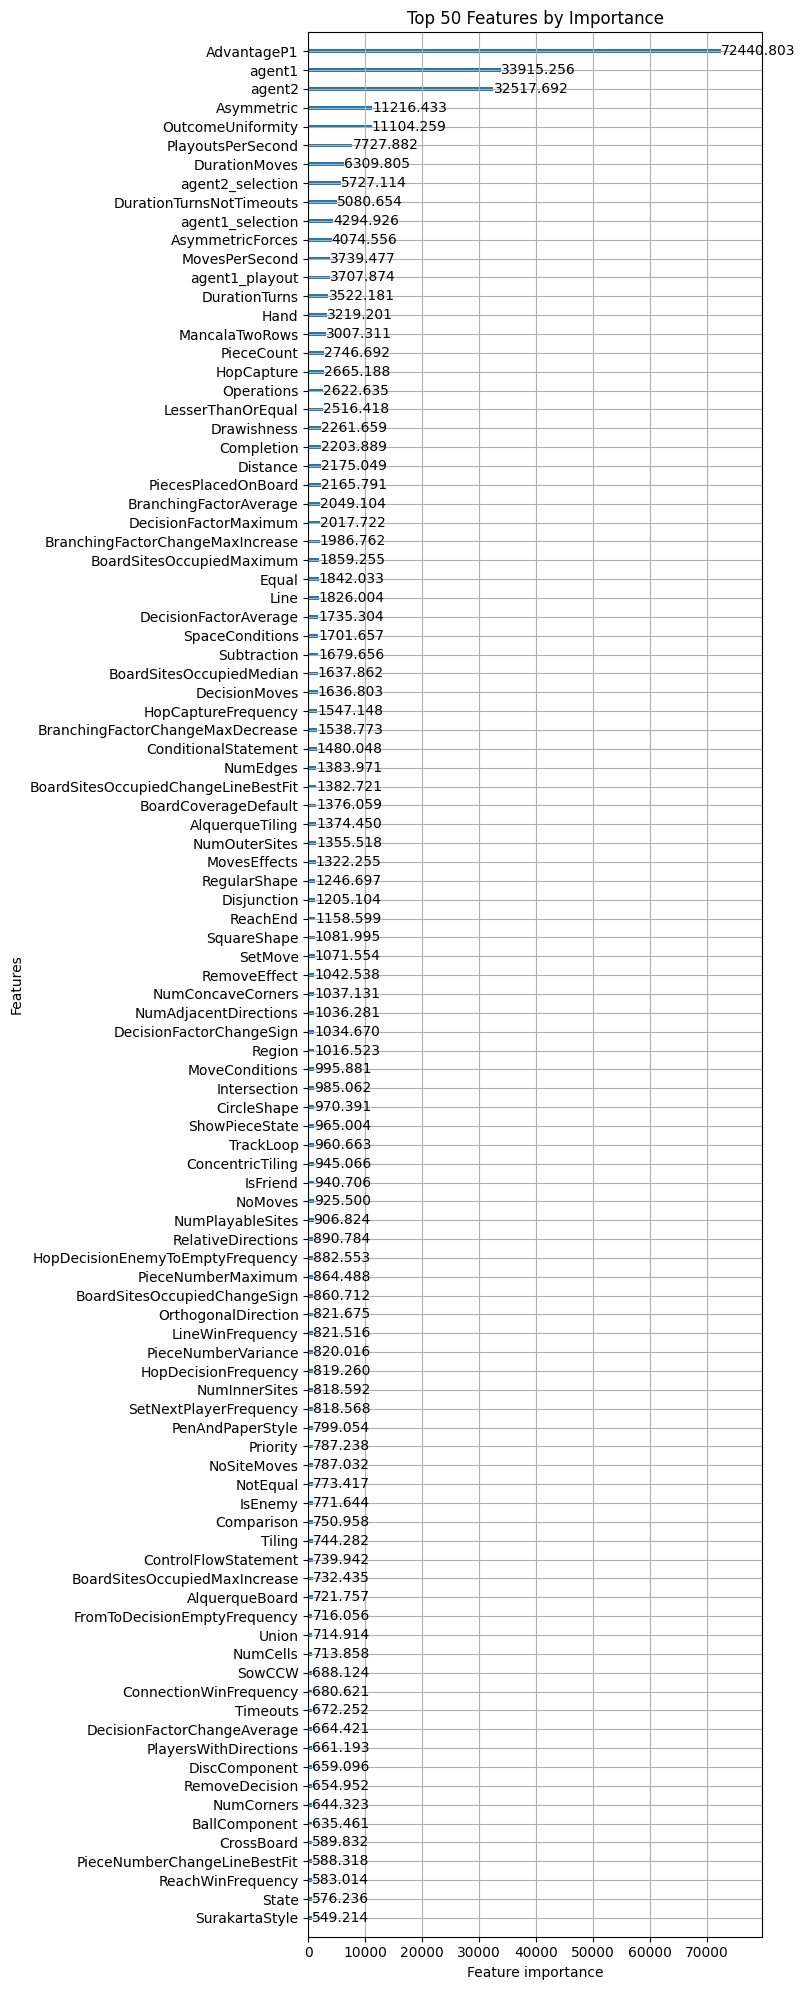

Fold 4 - RMSE: 0.46240695041810936
Fold 5


[50]	valid_0's rmse: 0.460173


[100]	valid_0's rmse: 0.443021


[150]	valid_0's rmse: 0.437117


[200]	valid_0's rmse: 0.433367


[250]	valid_0's rmse: 0.42887


[300]	valid_0's rmse: 0.427337


[350]	valid_0's rmse: 0.425195


[400]	valid_0's rmse: 0.423724


[450]	valid_0's rmse: 0.422905


[500]	valid_0's rmse: 0.422467


[550]	valid_0's rmse: 0.421624


[600]	valid_0's rmse: 0.420865


[650]	valid_0's rmse: 0.4204


[700]	valid_0's rmse: 0.419755


[750]	valid_0's rmse: 0.419345


[800]	valid_0's rmse: 0.418942


[850]	valid_0's rmse: 0.418804


[900]	valid_0's rmse: 0.41879


[950]	valid_0's rmse: 0.418415


[1000]	valid_0's rmse: 0.418199


[1050]	valid_0's rmse: 0.417773


[1100]	valid_0's rmse: 0.417598


[1150]	valid_0's rmse: 0.417518


[1200]	valid_0's rmse: 0.417267


[1250]	valid_0's rmse: 0.417193


[1300]	valid_0's rmse: 0.417106


[1350]	valid_0's rmse: 0.41713


[1400]	valid_0's rmse: 0.417247


[1450]	valid_0's rmse: 0.417293


[1500]	valid_0's rmse: 0.417206


[1550]	valid_0's rmse: 0.417287


[1600]	valid_0's rmse: 0.417216


[1650]	valid_0's rmse: 0.417193


[1700]	valid_0's rmse: 0.417124


[1750]	valid_0's rmse: 0.41702


[1800]	valid_0's rmse: 0.416921


[1850]	valid_0's rmse: 0.416971


[1900]	valid_0's rmse: 0.416959


[1950]	valid_0's rmse: 0.417032


[2000]	valid_0's rmse: 0.416942


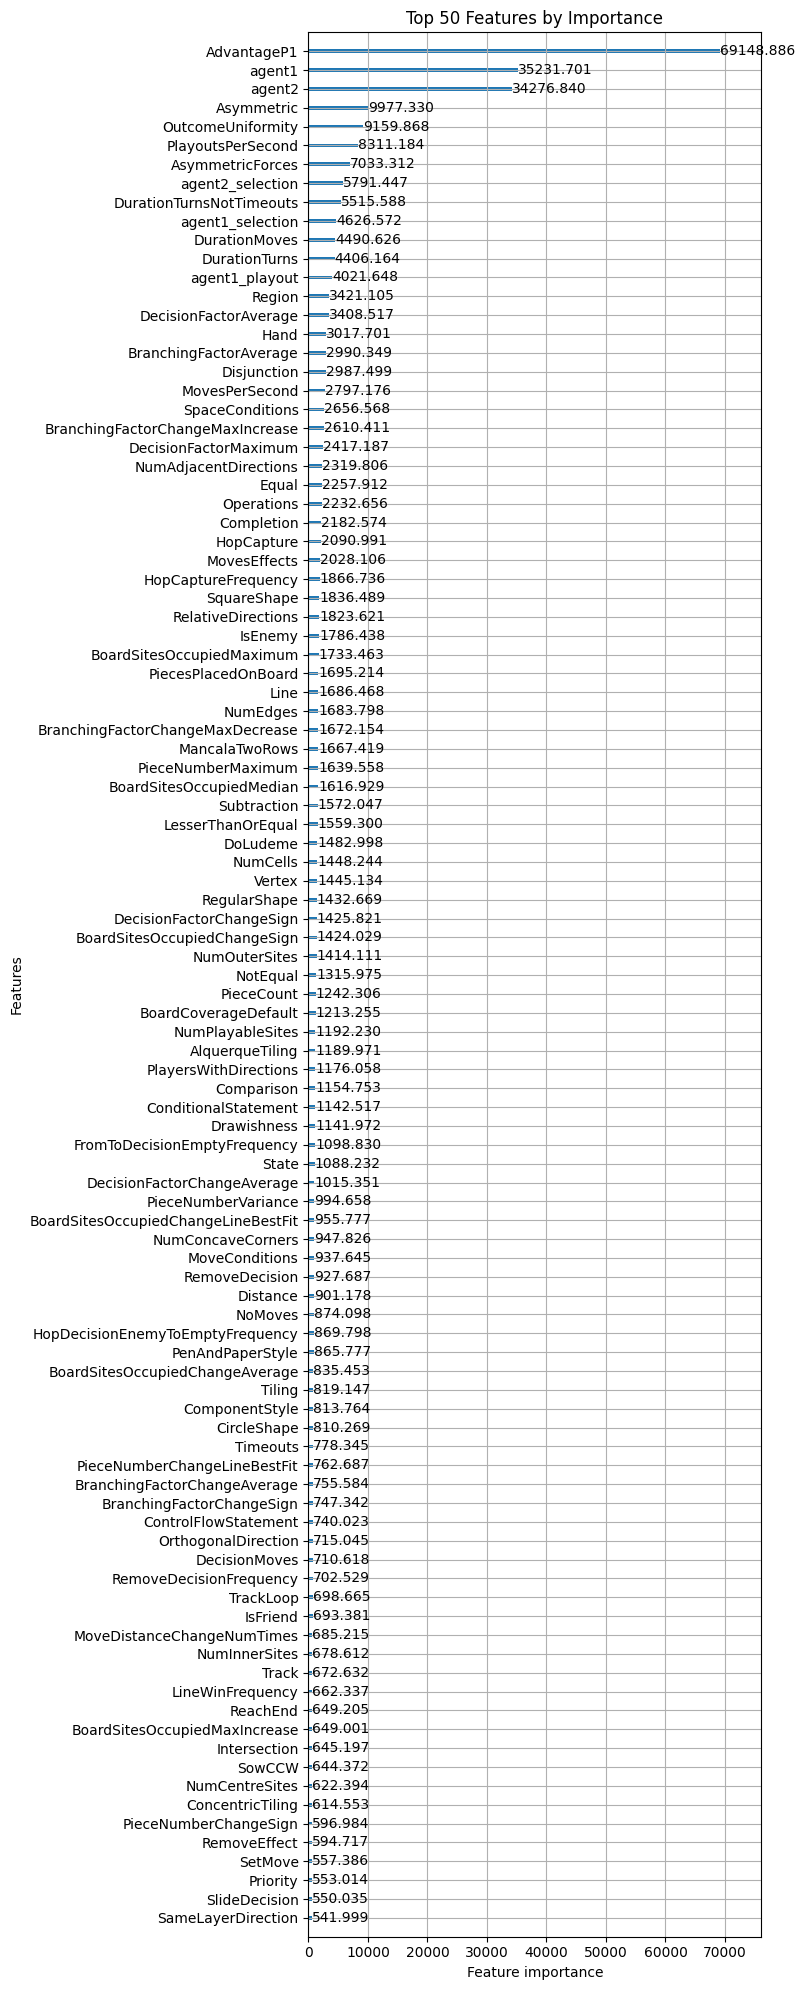

Fold 5 - RMSE: 0.4164720084834694
List of oof scores: [0.4347528759489758, 0.45103594175409284, 0.4418425431441224, 0.46240695041810936, 0.4164720084834694]
Average oof score: 0.44130206394975396


In [8]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_csv(path_results / 'oof_lightgbm_cv1.csv', index=False)
# save feature importance
importance_df1.to_csv(path_results / 'feat_importance_lightgbm_cv1.csv', index=False)


In [9]:
# # call the function
# trained_models2, oof2, oof_scores2 = train_models(
#     df_train,
#     numerical_cols,
#     categorical_cols,
#     num_folds=5,
#     cv_random_state=19,
# )
# # save oof predictions
# oof2.to_csv(path_results / 'oof_lightgbm_cv2.csv', index=False)

In [10]:
# # call the function
# trained_models3, oof3, oof_scores3 = train_models(
#     df_train,
#     numerical_cols,
#     categorical_cols,
#     num_folds=5,
#     cv_random_state=23,
# )
# # save oof predictions
# oof3.to_csv(path_results / 'oof_lightgbm_cv3.csv', index=False)

In [11]:
# trained_models = [*trained_models1, *trained_models2, *trained_models3]
trained_models = trained_models1

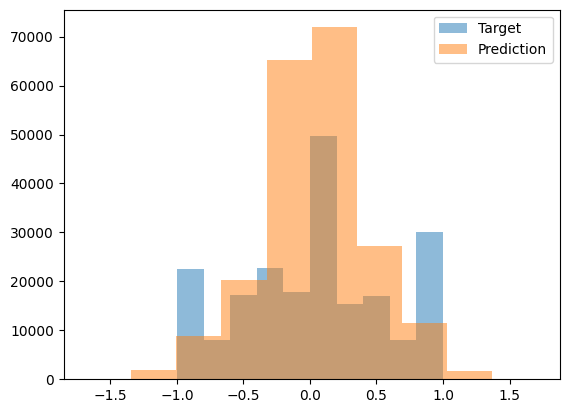

In [12]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [13]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [14]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [15]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

Id,utility_agent1
i64,f64
233234,0.095658
233235,-0.13669
233236,-0.01673


In [16]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [17]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open('./lightgbm_predict.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***